In [1]:
#!pip install keybert --quiet
#from keybert import KeyBERT
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas 
import numpy as np 
import re
import matplotlib
import seaborn as sb 
import time
from datasets import load_dataset

In [2]:
#get the number of words 
def getNumberOfWords(df):
    maxl=[]
    for i in range(len(df)):
        x= df["ATexte"][i].split()
        if len(x)< 3: print(i)
        maxl.append(len(x))
    print("Max value element : ", max(maxl))
    print("Min value element : ", min(maxl))
    return maxl

In [3]:
def plot_NumberOfWord(maxl, dataset_name):
    fig = plt.figure()
    ax1 = plt.axes()
    ax1.set_ylabel('number of words')
    ax1.set_title('number of words for each instance '+dataset_name)
    ind = np.arange(len(maxl))
    line, =ax1.plot(ind,maxl)
    plt.axhline(y=512, color="red", linestyle="--")
    fig.savefig(dataset_name+".png")
    plt.show()

In [4]:
def plotNumberSampleforeachCLASS(df, dataset_name):
    plot_=sb.countplot(df.MotsCles)
    new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
    matplotlib.pyplot.xticks(range(0, len(new_ticks), 10), new_ticks[::10], rotation='vertical')
    matplotlib.pyplot.xlabel("Number of sample for each class Distribution "+dataset_name)
    matplotlib.pyplot.savefig(dataset_name+'distribution.png')
    plt.show()

Downloading:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset lex_glue downloaded and prepared to /root/.cache/huggingface/datasets/lex_glue/ledgar/1.0.0/c3c0bd7433b636dc39ae49a84dc401190c73156617efc415b04e9835a93a7043. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


train 60000 sample


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


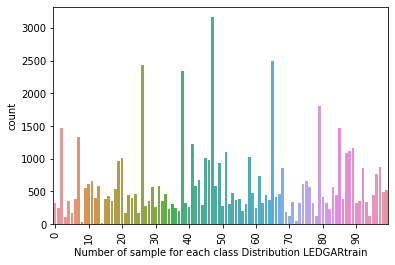

23049
Max value element :  1200
Min value element :  2


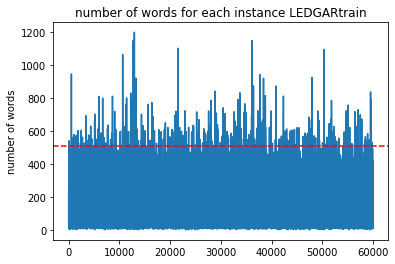

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


test 10000 sample


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


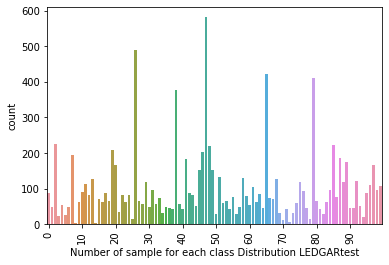

Max value element :  989
Min value element :  3


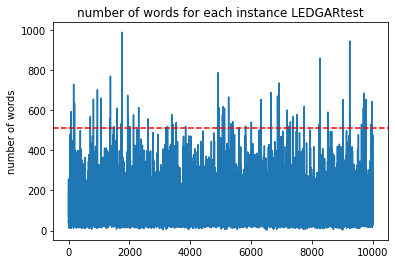

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


validation 10000 sample


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


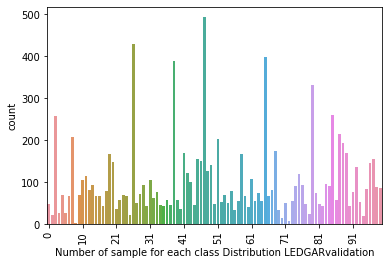

1861
9422
Max value element :  890
Min value element :  2


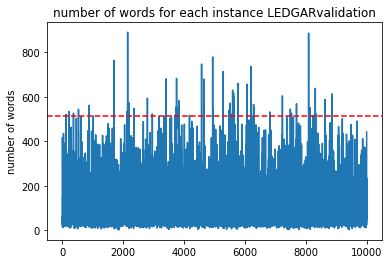

In [5]:
dataset = load_dataset("lex_glue", "ledgar")
DATASET_NAME='LEDGAR'
for x in dataset.keys():
    #get the train dataset
    dict = {'ATexte': dataset[x]["text"], 'MotsCles': dataset[x]["label"]}
    df = pandas.DataFrame(dict)
    df["ATexte"]= df["ATexte"].str.lower()
    for i in range(len(df)):
        df["ATexte"][i] = re.sub(r'[^a-z ]', '', df["ATexte"][i])
    print(x,len(df),"sample")
    plotNumberSampleforeachCLASS(df, DATASET_NAME+x)
    plot_NumberOfWord(getNumberOfWords(df), DATASET_NAME+x)
    df.to_csv("/kaggle/working/"+DATASET_NAME+x+".csv")
    #df = PreprocessLongTextwithKeyBERT(df, 3)
    #df = PreprocessLongTextwithKeyBERT(df, 1)
    #plot_NumberOfWord(getNumberOfWords(df), DATASET_NAME+x+"KeyBERT")
    #df.to_csv("/kaggle/working/"+DATASET_NAME+x+"KeyBERT.csv")

In [6]:
df=pandas.read_csv("./LEDGARtrain.csv")
print(df.head())

   Unnamed: 0                                             ATexte  MotsCles
0           0  except as otherwise set forth in this debentur...        97
1           1  no erisa event has occurred or is reasonably e...        39
2           2  this amendment may be executed by one or more ...        26
3           3  from time to time as and when required by the ...        45
4           4  commencing march   and during the employment p...        11


In [7]:
import random
random.seed(1)
text1=[]
text2=[]
correlated=[]
labels=[]
# 
for i in range (len(df)):
    row0 =df.iloc[i]
    # we exclud label 0 and 1 and 2 from the generated dataset for training 
    if row0["MotsCles"]==0 or row0["MotsCles"]==1 or row0["MotsCles"]==2:continue
    x=0
    y=0
    while x < 5:
        ind = random.randint(0, len(df)-1)
        if i ==ind : continue
        row =df.iloc[ind]
        if row0["MotsCles"]==row["MotsCles"]:
            text1.append(row0["ATexte"])
            text2.append(row["ATexte"])
            correlated.append(1)
            labels.append(str(row0["MotsCles"])+"=="+str(row["MotsCles"]))
            x=x+1
            
        
    while y < 5:
        ind = random.randint(0, len(df)-1)
        if i ==ind : continue
        row =df.iloc[ind]
        if row0["MotsCles"]!=row["MotsCles"]:
            text1.append(row0["ATexte"])
            text2.append(row["ATexte"])
            correlated.append(0)
            labels.append(str(row0["MotsCles"])+"!="+str(row["MotsCles"]))
            y=y+1
    #break
dict = {'ATexte':text1 , 'MotsCles':text2, 'correlated':correlated, 'labels':labels } 
df7 = pandas.DataFrame(dict)              
print(len(df7))
#print(df7["MotsCles"][0])
#print(df7["ATexte"][0])
print(df7.head())
#df7.to_csv("/kaggle/working/lexglueledgarTronsformed.csv")

579550
                                              ATexte  \
0  except as otherwise set forth in this debentur...   
1  except as otherwise set forth in this debentur...   
2  except as otherwise set forth in this debentur...   
3  except as otherwise set forth in this debentur...   
4  except as otherwise set forth in this debentur...   

                                            MotsCles  correlated  labels  
0  bank hereby waives borrowers compliance with s...           1  97==97  
1  borrower hereby waives and releases all benefi...           1  97==97  
2  the participants or the companys failure to in...           1  97==97  
3  the failure of landlord or tenant to insist in...           1  97==97  
4  landlords delay waiver or nonenforcement of ac...           1  97==97  


In [8]:
!pip install sentence-transformers --quiet
train, validate = np.split(df7.sample(frac=1, random_state=42),[int(.9*len(df7))])
#print(len(df7))
#print(len(train))
#print(len(validate))
#print(train.head())
from sentence_transformers import InputExample
dev_samples=[]
train_samples=[]
for i in range(len(train)):
        row =train.iloc[i]
        #As we want to get symmetric scores, i.e. CrossEncoder(A,B) = CrossEncoder(B,A), we pass both combinations to the train set
        train_samples.append(InputExample(texts=[row["ATexte"], row["MotsCles"]], label=float(row["correlated"])))
        #break
for i in range(len(validate)):
        row =validate.iloc[i]
        dev_samples.append(InputExample(texts=[row["ATexte"], row["MotsCles"]], label=float(row["correlated"])))
        #break
#print(train_samples[:10])

In [9]:
import pickle
import torch
lexglueLedgar = {'train_samples':train_samples, 'dev_samples':dev_samples}
with open('/kaggle/working/lexglueLedgar012.pickle', 'wb') as handle:
    pickle.dump(lexglueLedgar, handle, protocol=pickle.HIGHEST_PROTOCOL)